In [1]:
import numpy as np
import pandas as pd
import eikon as ek
ek.set_app_key('b4229eae2c644ec8a0aab0bb0fb83b13a38eb2c7')
import cufflinks as cf
import configparser as cp
cf.set_config_file(offline = True)
from datetime import datetime
from datetime import timedelta
import scipy as sp
import scipy.stats as si
import sympy as sy
import sympy.stats as systats
from IPython.display import display_html
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas.plotting import table 
import matplotlib
import seaborn as sns
from IPython.display import HTML
from arch import arch_model
from numpy.linalg import inv
from scipy.optimize import fmin_slsqp

import plotly.express as px
import plotly.graph_objects as go
import chart_studio
from chart_studio.plotly import plot, iplot
import chart_studio.plotly as py
from PIL import Image as im
#import Lido_funcs3 as lf

import time


import IPython.display
from IPython.display import Image
chart_studio.tools.set_credentials_file(username='JGarden79', api_key='eWGoAmjzRp3GIVRTFfSR')

import chart_studio.tools as tls

import plotly.io as pio

import plotly.figure_factory as ff
import DatastreamDSWS as DSWS
ds = DSWS.Datastream(username = 'JGarden1@lidoadvisors.com', password= 'Welcome2')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from plotly.subplots import make_subplots
import os

if not os.path.exists("images"):
    os.mkdir("images")
    


In [2]:

###Import SPY data and create constituant list
hold = ek.get_data('SPY', fields = [ek.TR_Field('TR.ETPConstituentRIC',params={'SDate':'2020-10-06'})])[0]
hold = hold[hold['Constituent RIC'] != 'GOOG.OQ']
rics = [x for x in hold['Constituent RIC']]
if 'GOOG.OQ' in rics == True:
    rics.remove('GOOG.OQ')


In [3]:

###Import Sector and valuation data
fields = [ek.TR_Field('TR.GICSSectorCode'),ek.TR_Field('TR.FwdPE', params={'Period':'NTM'}), ek.TR_Field('TR.PriceToBVPerShare'), ek.TR_Field('TR.EVToOperatingCashFlow')]
data = ek.get_data(rics, fields = fields)[0]

In [4]:
#Remove RE and Financials as standard valuation metrics don't apply to these in the same way as the other sectors:
data = data[data['GICS Sector Code']!='40'] 
data = data[data['GICS Sector Code']!='60']

In [29]:
###Create training set
#### The training set consists of names included in the S&P 500 PURE VALUE and PURE GROWTH indices and serve as a proxie for what "TRUE" VALUE/GROWTH stocks look like

pure_val = ek.get_data('RPV', fields = [ek.TR_Field('TR.ETPConstituentRIC',params={'SDate':'2020-10-07'})])[0] ####Import HOLDINGS of Pure Value
test_rics_val = [x for x in pure_val['Constituent RIC']] #### Move holdings to list for later use
time.sleep(15)

pure_gr = ek.get_data('RPG', fields = [ek.TR_Field('TR.ETPConstituentRIC',params={'SDate':'2020-10-07'})])[0] ####Import HOLDINGS of Pure Growth
test_rics_gro = [x for x in pure_gr['Constituent RIC']]#### Move to list for later use

train = pd.DataFrame() ####Establish empty DF

###Create the Actual classifications of "PURE VALUE/GROWTH" using a Binary Classifier
for i in range(0, len(test_rics_val)):####Iterate over a range equal to the number of rics in Value
    x = data[data['Instrument'] == test_rics_val[i]] ###look for each "PURE VALUE" RIC in the complete dataset
    x['Class'] = 1 #### Add a classification value in a new column 1 for value 0 for growth
    train = pd.concat([train, x]) ###add the observation (row) to the training data frame
    
for i in range(0, len(test_rics_gro)): ###***SEE ABOVE***
    x = data[data['Instrument'] == test_rics_gro [i]]
    x['Class'] = 0
    train = pd.concat([train, x])
    
train = train.dropna()####Remove missing data


train = train.sample(frac=1, replace=True, random_state = 42)#### here we create our training data set by randomly selecting data from the training data frame, every item selected is replaced 



In [30]:
train

,Instrument,GICS Sector Code,Forward P/E (Daily Time Series Ratio),Price To Book Value Per Share (Daily Time Series Ratio),Enterprise Value To Operating Cash Flow (Daily Time Series Ratio),Class
112,PHM.N,25,7.532821,1.746597,6.723453,0
103,LMT.N,20,14.057925,20.558711,14.105046,0
233,AZO.N,25,14.970219,-31.076542,11.275291,0
39,ALL.N,40,7.698123,1.046934,6.804282,1
395,CHTR.OQ,50,43.896837,4.555245,15.085936,0
...,...,...,...,...,...,...
272,CBOE.Z,40,17.328754,2.823979,7.094706,0
338,NUE.N,15,16.673740,1.487437,6.213340,1
198,KSU.N,20,22.430818,3.865616,19.441713,0
31,BEN.N,40,7.597959,1.000124,9.018696,1


In [84]:
###Set up data for GBDecision Tree Train and Test
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics


X = train.drop(['Instrument','Class', 'GICS Sector Code'], axis = 1)###This is a DF of features to be fed into the model
lims = X.quantile(0.1)
lims_2 = X.quantile(0.9)
X = X.clip(lims, lims_2, axis = 1)
sect = train['GICS Sector Code'].to_list()
X['GICS Sector Code'] = sect
y = train['Class'] ### These are classifications used to train and test the model befor we apply to our out of sample 


X_train, X_test, y_train,y_test = train_test_split(X, y) #### randomly split test data into training and testing data



In [124]:
###Fit Classification Algo and apply to test data, check accuracy 
clf = GradientBoostingClassifier(learning_rate=0.01, n_estimators=150, random_state=42, max_depth=2).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_test = clf.score(X_test, y_test)
accuracy_train, accuracy_test


(0.9305555555555556, 0.9166666666666666)

In [125]:
###Apply model to evaluation set (out of sample data)
X_eval = data.drop(['Instrument'], axis = 1).dropna()
sect = X_eval['GICS Sector Code'].to_list()
X_eval = X_eval.drop(['GICS Sector Code'], axis=1)
lims = X_eval.quantile(0.1)
lims_2 = X_eval.quantile(0.9)
X_eval = X_eval.clip(lims, lims_2, axis = 1)
X_eval['GICS Sector Code'] = sect


OS_res = clf.predict(X_eval)
OS_probs = clf.predict_proba(X_eval)

clf_results = data.dropna()
clf_results['Predictions'] = OS_res
clf_results['Probs'] = [p[0] for p in OS_probs ]

In [126]:
###This will look all stocks included in the "VALUE" Index of the S&P 500 
SPYV = ek.get_data('SPYV.K', fields = [ek.TR_Field('TR.ETPConstituentRIC',params={'SDate':'2020-10-07'})])[0]
actuals = [x for x in SPYV['Constituent RIC']]
j = clf_results['Instrument'].tolist()
y_real = []

for i in j:
    if i in actuals:
        y_real.append(1)
    else:
        y_real.append(0)

clf_results['Actuals'] = y_real

###The loop basicly adds the classification based on membership in the VALUE ETF, this also has implications for overlapping securities (they will be considerd value) 



In [127]:
accu = metrics.accuracy_score(clf_results['Actuals'], clf_results['Predictions'])
y_eval = clf_results['Predictions'].to_numpy()

In [128]:
clf_results['hits'] = abs(clf_results['Predictions'] - clf_results['Actuals'])
clf_results['hits'] = clf_results['hits'].replace(0, 'green')
clf_results['hits'] = clf_results['hits'].replace(0, 'red')

In [129]:
accu

0.5203426124197003

In [130]:
import adspy_shared_utilities as asu

In [133]:
feat_names = data.drop(['Instrument'], axis = 1).columns.to_numpy()

print(feat_names, clf.feature_importances_)

['GICS Sector Code' 'Forward P/E (Daily Time Series Ratio)'
 'Price To Book Value Per Share (Daily Time Series Ratio)'
 'Enterprise Value To Operating Cash Flow (Daily Time Series Ratio)'] [0.13375703 0.42215536 0.41900082 0.02508679]


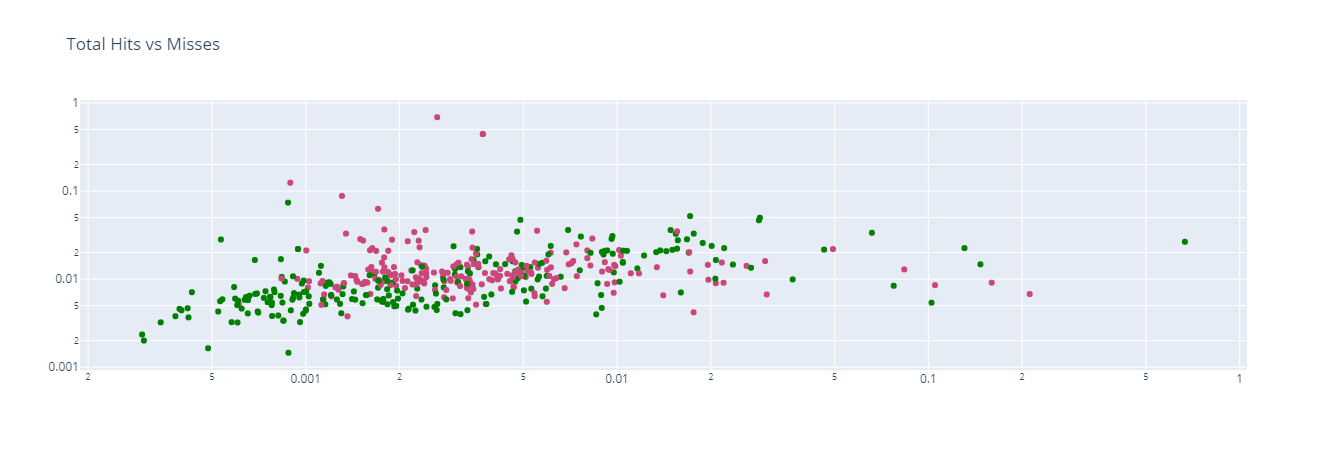

In [136]:
from sklearn.preprocessing import normalize

X = clf_results['Price To Book Value Per Share (Daily Time Series Ratio)'].to_numpy()
X_norm = normalize(X.reshape(1,-1))
X_list = list(X_norm[0])

Y = clf_results['Forward P/E (Daily Time Series Ratio)'].to_numpy()
Y_norm = normalize(Y.reshape(1,-1))
Y_list = list(Y_norm[0])

color = clf_results['hits'].to_list()
text = clf_results['Instrument'].to_list()

fig = go.Figure(data = go.Scatter(
    x=X_list,
    y=Y_list,
    mode='markers',
    text= text,
    marker = dict(color = color)))
fig.update_yaxes(type="log")
fig.update_xaxes(type="log")
fig.update_layout(title= 'Total Hits vs Misses')


fig.show()

In [106]:
cfm = confusion_matrix(clf_results['Actuals'],clf_results['Predictions'])
CFM = cfm/len(clf_results['Actuals'])
print(CFM)

[[0.21627409 0.02141328]
 [0.45824411 0.30406852]]


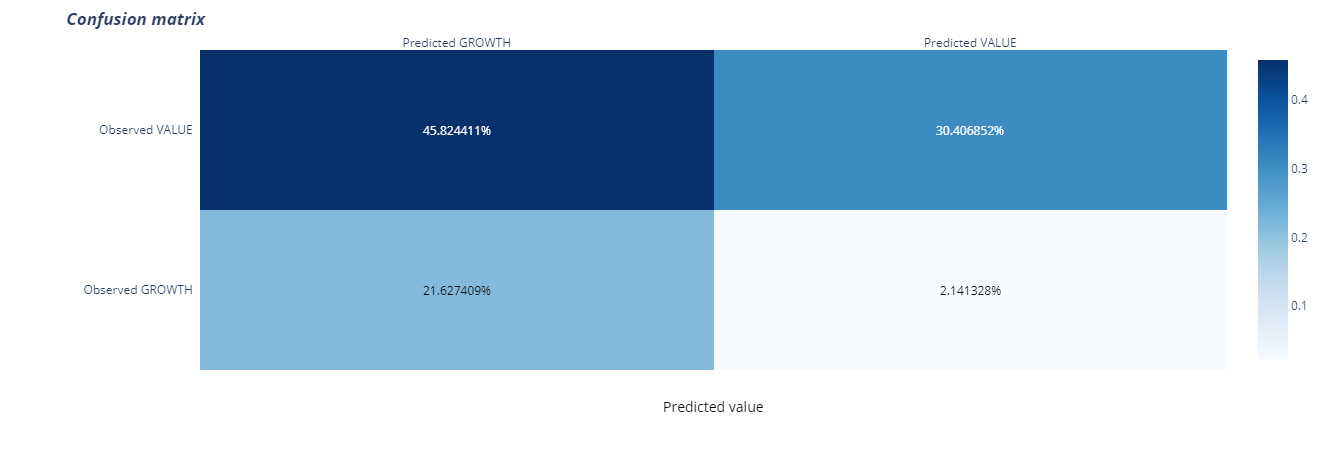

In [107]:
import plotly.figure_factory as ff
x = ['Predicted GROWTH' , 'Predicted VALUE']
y = ['Observed GROWTH', 'Observed VALUE']

CFM_text =[['{:2%}'.format(CFM[0][0]), '{:2%}'.format(CFM[0][1])],['{:2%}'.format(CFM[1][0]),'{:2%}'.format(CFM[1][1])]]
fig = ff.create_annotated_heatmap(CFM, x=x, y=y, annotation_text=CFM_text, colorscale='blues')

fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()


In [108]:
from sklearn.metrics import plot_confusion_matrix

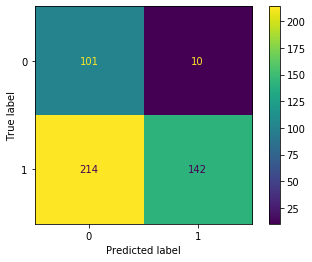

In [109]:
plot_confusion_matrix(clf, X_eval, clf_results['Actuals'], values_format ='d',)

In [20]:
clf.feature_importances_

array([0.04496386, 0.18662244, 0.25005797, 0.51835573])

In [21]:
clf_results

,Instrument,GICS Sector Code,Forward P/E (Daily Time Series Ratio),Price To Book Value Per Share (Daily Time Series Ratio),Enterprise Value To Operating Cash Flow (Daily Time Series Ratio),Predictions,Probs,Actuals,hits
0,SHW.N,15,26.332215,14.907662,21.841173,0,0.883485,0,green
1,DTE.N,55,18.154593,2.023242,12.418932,1,0.485067,1,green
2,LOW.N,25,17.928068,26.631818,10.031905,1,0.454694,1,green
3,WBA.OQ,30,8.158641,1.668671,9.203912,1,0.431898,1,green
4,MAR.OQ,25,44.855652,167.531397,22.562059,0,0.891970,0,green
...,...,...,...,...,...,...,...,...,...
498,CI.N,35,10.436945,1.653245,13.291225,1,0.208036,1,green
499,FIS.N,45,21.940846,1.791679,28.061981,0,0.751622,1,1
500,FTNT.OQ,45,32.828239,26.650243,17.751646,0,0.891970,0,green
501,TXN.OQ,45,27.198365,17.219692,25.083204,0,0.891970,1,1


In [22]:
featurs = pd.DataFrame({'Price To Book Value Per Share (Daily Time Series Ratio)':X_list, 'Enterprise Value To Operating Cash Flow (Daily Time Series Ratio)': Y_list})

In [23]:
featurs['Predictions'] = clf_results['Predictions']
featurs

,Price To Book Value Per Share (Daily Time Series Ratio),Enterprise Value To Operating Cash Flow (Daily Time Series Ratio),Predictions
0,0.011622,0.000983,0.0
1,0.001577,0.000559,1.0
2,0.020762,0.000451,1.0
3,0.001301,0.000414,1.0
4,0.130606,0.001015,0.0
...,...,...,...
462,0.001289,0.000598,0.0
463,0.001397,0.001263,0.0
464,0.020776,0.000799,0.0
465,0.013424,0.001129,0.0


In [24]:
clf_results

,Instrument,GICS Sector Code,Forward P/E (Daily Time Series Ratio),Price To Book Value Per Share (Daily Time Series Ratio),Enterprise Value To Operating Cash Flow (Daily Time Series Ratio),Predictions,Probs,Actuals,hits
0,SHW.N,15,26.332215,14.907662,21.841173,0,0.883485,0,green
1,DTE.N,55,18.154593,2.023242,12.418932,1,0.485067,1,green
2,LOW.N,25,17.928068,26.631818,10.031905,1,0.454694,1,green
3,WBA.OQ,30,8.158641,1.668671,9.203912,1,0.431898,1,green
4,MAR.OQ,25,44.855652,167.531397,22.562059,0,0.891970,0,green
...,...,...,...,...,...,...,...,...,...
498,CI.N,35,10.436945,1.653245,13.291225,1,0.208036,1,green
499,FIS.N,45,21.940846,1.791679,28.061981,0,0.751622,1,1
500,FTNT.OQ,45,32.828239,26.650243,17.751646,0,0.891970,0,green
501,TXN.OQ,45,27.198365,17.219692,25.083204,0,0.891970,1,1


In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

MemoryError: Unable to allocate 50.0 GiB for an array with shape (9115, 736957) and data type float64

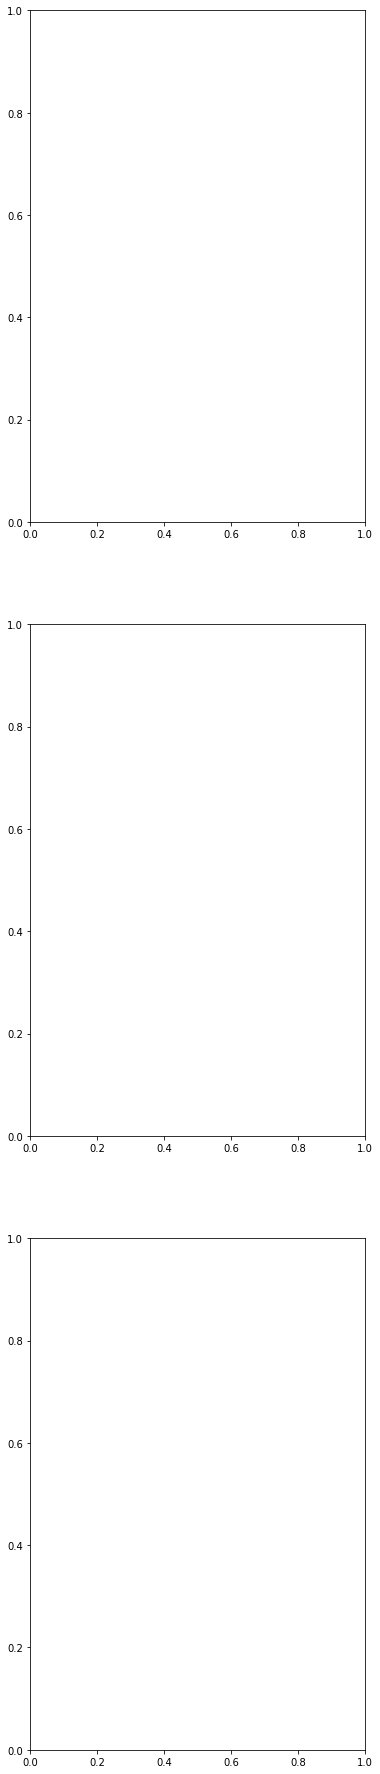

In [26]:
X = train.drop(['Instrument','Class'], axis = 1)
y = train['Class']
X_train, X_test, y_train,y_test = train_test_split(X.values, y.values)


feat_lists = ['GICS Sector Code', 'Forward P/E (Daily Time Series Ratio)',
       'Price To Book Value Per Share (Daily Time Series Ratio)',
       'Enterprise Value To Operating Cash Flow (Daily Time Series Ratio)']

tgt_names = ['Growth', 'Value']

title = 'Gradient Boosted Classification Value/Growth'

fig, subaxes = plt.subplots(3, 1, figsize=(6, 32))

pair_list = [[3,2], [3,1], [2,1]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    X_t = X_test[:, pair]
    y_t = y_test
    
    clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=2).fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, X_t,
                                         y_t, title, axis,tgt_names)
    
    axis.set_xlabel(feat_lists[pair[0]])
    axis.set_ylabel(feat_lists[pair[1]])
    
plt.tight_layout()
plt.show()

In [ ]:
X = train.drop(['Instrument','Class'], axis = 1)
y = train['Class']

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X.values, y.values)

In [ ]:
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [ ]:
norm_X_eval = MinMaxScaler().fit(X_eval).transform(X_eval)

In [ ]:
kmeans = KMeans(n_clusters=2).fit(norm_X_eval)

In [ ]:
len(kmeans.labels_)

In [ ]:
from adspy_shared_utilities import plot_labelled_scatter

In [ ]:
plot_labelled_scatter(norm_X_eval, kmeans.labels_, ['Growth', 'Value'])

In [ ]:
norm_X_eval

In [ ]:
clusts = []
for k in kmeans.labels_:
    if k == 1:
        clusts.append(1)
    else:
        clusts.append(0)

clf_results['clust'] = clusts
clf_results

In [ ]:
accu2 = metrics.accuracy_score(clf_results['Actuals'], clf_results['clust'])

In [ ]:
accu2

In [ ]:
from scipy.stats.mstats import winsorize

In [ ]:
k = data.dropna()
k = k[k['GICS Sector Code']!=40] 
k = k[k['GICS Sector Code']!=60]
k_inst = list(k['Instrument'])
k_sec = list(k['GICS Sector Code'])
k = k.drop(['Instrument', 'GICS Sector Code'],axis=1)
lims = k.quantile(0.1)
lims_2 = k.quantile(0.9)
k = k.clip(lims, lims_2, axis=1)


In [ ]:
norm_X_eval = MinMaxScaler().fit(k).transform(k)

In [ ]:
k['GICS Sector Code'] = k_sec
k['STOCKS'] = k_inst

In [ ]:
norm_X_eval

In [ ]:
kmeans = KMeans(n_clusters=2).fit(norm_X_eval)

In [ ]:
k['results'] = kmeans.labels_

In [ ]:
k['actuals'] = clf_results['Actuals']

In [ ]:
k

In [ ]:
accu2 = metrics.accuracy_score(k['actuals'], k['results'])

In [ ]:
import plotly.graph_objects as go

In [ ]:
X=list(k['Price To Book Value Per Share (Daily Time Series Ratio)'])
Y = list(k['Enterprise Value To Operating Cash Flow (Daily Time Series Ratio)'])
text = list(k['STOCKS'])
color = ['#00274C' if i==1 else '#FFCB05' for i in list(k['results']) ]

fig = go.Figure()
fig.add_trace(go.Scatter(x=X, y=Y, mode = 'markers', text = text, marker = dict(color = color)))
fig.show()

In [ ]:
accu2

In [ ]:
kmeans.cluster_centers_

In [ ]:
X=list(k['Price To Book Value Per Share (Daily Time Series Ratio)'])
Y = list(k['Forward P/E (Daily Time Series Ratio)'])
text = list(k['STOCKS'])
color = ['#00274C' if i==1 else '#FFCB05' for i in list(k['results']) ]

fig = go.Figure()
fig.add_trace(go.Scatter(x=X, y=Y, mode = 'markers', text = text, marker = dict(color = color)))
fig.show()

In [ ]:
X=list(k['Enterprise Value To Operating Cash Flow (Daily Time Series Ratio)'])
Y = list(k['Forward P/E (Daily Time Series Ratio)'])
text = list(k['STOCKS'])
color = ['#00274C' if i==1 else '#FFCB05' for i in list(k['results']) ]

fig = go.Figure()
fig.add_trace(go.Scatter(x=X, y=Y, mode = 'markers', text = text, marker = dict(color = color)))
fig.show()

In [ ]:
Y=list(k['Price To Book Value Per Share (Daily Time Series Ratio)'])
X = list(k['GICS Sector Code'])
text = list(k['STOCKS'])
color = ['#00274C' if i==1 else '#FFCB05' for i in list(k['results']) ]

fig = go.Figure()
fig.add_trace(go.Scatter(x=X, y=Y, mode = 'markers', text = text, marker = dict(color = color)))
fig.show()